In [19]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot
import math


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [20]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [21]:
df = pd.read_csv(proc_cfg(config['lr']['exons_ss_in_pops_fsts_summary_60nt'], od),
                 sep='\t')
df.rename({'pop2_der':'pop2_det'}, 
          axis=1, inplace=True)

# set all <0 fsts --> 0 https://www.biostars.org/p/132253/
df.loc[df.fst<0, 'fst'] = 0

# since this is biallelic snp level, remove all exons that didnt intersect
print(len(df.index))
df = df.loc[df.End_b!=-1]
print(len(df.index))
df.to_csv('250213_snp_exon_60bp_intersect_fst.tsv', sep='\t')


3974269
3297390


In [4]:
# 1. limit to just contrasts that involve CEU
df = df.loc[(df.pop1=='CEU')|(df.pop2=='CEU')]

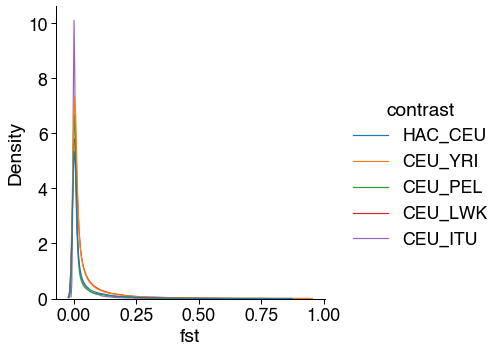

In [5]:
# plot distribution of Fsts
df['contrast'] = df.pop1+'_'+df.pop2
init_plot_settings()
ax = sns.displot(df, 
            x='fst',
            hue='contrast',
            kind='kde')      

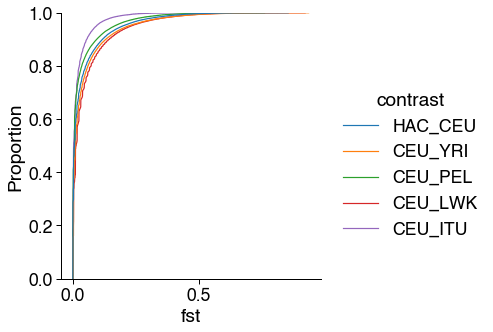

In [6]:
# plot distribution of Fsts
df['contrast'] = df.pop1+'_'+df.pop2
init_plot_settings()
ax = sns.displot(df, 
            x='fst',
            hue='contrast',
            kind='ecdf')      

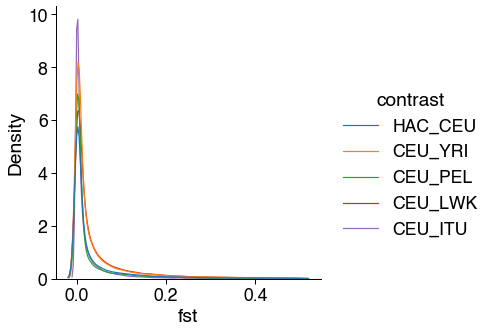

In [7]:
# plot distribution of Fsts
temp = df.loc[df.fst<0.5]
init_plot_settings()
ax = sns.displot(temp, 
            x='fst',
            hue='contrast',
            kind='kde')      

In [8]:
# 2. call variant positions as divergent or non-divergent
div_thresh = 0.2
df['divergent'] = df.fst>=div_thresh

In [9]:
# loop through each contrast
cont_df = pd.DataFrame()
stat_df = pd.DataFrame()
for nov in ["Novel 5'/3'", 'Novel']:
    for pop1, pop2 in zip(df[['pop1', 'pop2']].drop_duplicates()['pop1'].tolist(),
                          df[['pop1', 'pop2']].drop_duplicates()['pop2'].tolist()):
        temp = df.loc[(df.pop1==pop1)&(df.pop2==pop2)]
        temp.rename({'pop1_det':pop1,
                 'pop2_det':pop2}, axis=1, inplace=True)
        
        # ensure we're always talking about uniq exon+variant pos pairs
        assert len(temp.index) == len(temp[['eid', 'End_b', 'Start_b']].drop_duplicates())

        # 3. compute contingency table and test
        # columns --> intersects novel exon; intersects any exon
        # rows --> highly divergent vs. not divergent

        non_ceu_pop = [p for p in [pop1, pop2] if p != 'CEU'][0]

        # testing variants
        # - intersecting novel exons ONLY detected in the non-CEU pop
        nov_uniq_df = temp.loc[(temp[non_ceu_pop]==True)&\
                               (temp['CEU']==False)&\
                               (temp.novelty==nov)]
        nov_uniq_df = nov_uniq_df[['divergent', 'eid']].groupby('divergent').count().rename({'eid':'n_var_exon_pairs'}, axis=1).reset_index()
        nov_uniq_col = f'{nov}, {non_ceu_pop}-unique'
        nov_uniq_df['label'] = nov_uniq_col

        # background varians
        # - intersecting known or novel exons which are detected in both
        bg_df = temp.loc[(temp[non_ceu_pop]==True)&\
                         (temp['CEU']==True)]
        bg_df = bg_df[['divergent', 'eid']].groupby('divergent').count().rename({'eid':'n_var_exon_pairs'}, axis=1).reset_index()
        bg_col = f'{non_ceu_pop}-CEU shared'
        bg_df['label'] = bg_col

        temp = pd.concat([nov_uniq_df, bg_df], axis=0)

        temp = temp.pivot(index='divergent',
                          values = 'n_var_exon_pairs',
                          columns = 'label')
        temp = temp.sort_index()
        temp = temp[[bg_col, nov_uniq_col]]
        print(temp)
        
        temp = temp.values

        # Perform Fisher's Exact Test
        odds_ratio, p_value = st.fisher_exact(temp, alternative='greater')

        print(f'{pop1} vs. {pop2}')
        print(f'Hypoth: variant positions intersecting {nov} exons are enriched for being divergent')
        print("Odds Ratio:", odds_ratio)
        print("P-value:", p_value)
        print()
        
        temp3 = pd.DataFrame(data=[[pop1, pop2, odds_ratio, p_value, nov]], 
                         columns=['pop1', 'pop2', 'odds_ratio', 'pval', 'novelty'])
        stat_df = pd.concat([stat_df, temp3], axis=0)        

label      HAC-CEU shared  Novel 5'/3', HAC-unique
divergent                                         
False              119151                     2697
True                 5948                      162
HAC vs. CEU
Hypoth: variant positions intersecting Novel 5'/3' exons are enriched for being divergent
Odds Ratio: 1.2032636576693974
P-value: 0.014999995518976714

label      YRI-CEU shared  Novel 5'/3', YRI-unique
divergent                                         
False              182810                     3064
True                10997                      226
CEU vs. YRI
Hypoth: variant positions intersecting Novel 5'/3' exons are enriched for being divergent
Odds Ratio: 1.2261550800348826
P-value: 0.0023853248683609342

label      PEL-CEU shared  Novel 5'/3', PEL-unique
divergent                                         
False              117949                     2527
True                 4332                       88
CEU vs. PEL
Hypoth: variant positions intersecting Novel 5'

In [10]:
stat_df.head()
stat_df['contrast'] = stat_df.pop1+'_'+stat_df.pop2
stat_df.head()

,pop1,pop2,odds_ratio,pval,novelty,contrast
0,HAC,CEU,1.203264,0.015000,Novel 5'/3',HAC_CEU
0,CEU,YRI,1.226155,0.002385,Novel 5'/3',CEU_YRI
0,CEU,PEL,0.948164,0.701299,Novel 5'/3',CEU_PEL
0,CEU,LWK,1.078530,0.171669,Novel 5'/3',CEU_LWK
0,CEU,ITU,0.933448,0.647575,Novel 5'/3',CEU_ITU


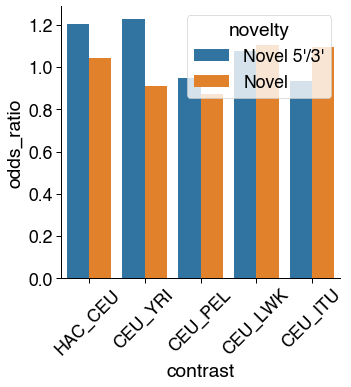

In [11]:
ax = sns.barplot(stat_df, 
            y='odds_ratio', 
            hue='novelty',
            x='contrast')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', rotation=45)

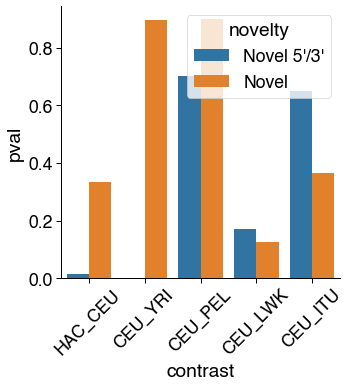

In [12]:
ax = sns.barplot(stat_df, 
            y='pval', 
            hue='novelty',
            x='contrast')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', rotation=45)

In [13]:
stat_df

,pop1,pop2,odds_ratio,pval,novelty,contrast
0,HAC,CEU,1.203264,0.015000,Novel 5'/3',HAC_CEU
0,CEU,YRI,1.226155,0.002385,Novel 5'/3',CEU_YRI
0,CEU,PEL,0.948164,0.701299,Novel 5'/3',CEU_PEL
0,CEU,LWK,1.078530,0.171669,Novel 5'/3',CEU_LWK
0,CEU,ITU,0.933448,0.647575,Novel 5'/3',CEU_ITU
0,HAC,CEU,1.043007,0.333724,Novel,HAC_CEU
0,CEU,YRI,0.911088,0.896164,Novel,CEU_YRI
0,CEU,PEL,0.872468,0.897806,Novel,CEU_PEL
0,CEU,LWK,1.104861,0.125535,Novel,CEU_LWK
0,CEU,ITU,1.093237,0.366097,Novel,CEU_ITU


In [14]:
stat_df['sig'] = stat_df.pval<=0.05

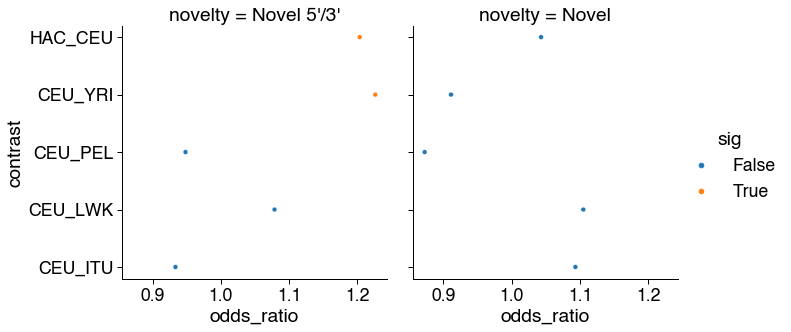

In [15]:
sns.relplot(stat_df,
                y='contrast',
                x='odds_ratio', 
                hue='sig', 
                col='novelty',
                sizes=(100, 100))
                

In [16]:
# loop through each contrast
stat_df = pd.DataFrame()
for nov in ["Novel 5'/3'", 'Novel']:
    for pop1, pop2 in zip(df[['pop1', 'pop2']].drop_duplicates()['pop1'].tolist(),
                          df[['pop1', 'pop2']].drop_duplicates()['pop2'].tolist()):
        temp = df.loc[(df.pop1==pop1)&(df.pop2==pop2)]
        temp.rename({'pop1_det':pop1,
                 'pop2_det':pop2}, axis=1, inplace=True)
        
        # ensure we're always talking about uniq exon+variant pos pairs
        assert len(temp.index) == len(temp[['eid', 'End_b', 'Start_b']].drop_duplicates())
        
        temp = temp.loc[temp.novelty.isin([nov, 'Known'])]
        break
    break

In [17]:
temp = temp[['eid', 'novelty', 'divergent']].groupby(['novelty', 'divergent']).count().reset_index().rename({'eid':'n_var_exon_pairs'},axis=1)
temp
temp = temp.pivot(index='divergent',
                  values = 'n_var_exon_pairs',
                  columns = 'novelty')
temp

novelty,Known,Novel 5'/3'
divergent,,
False,154465,8122
True,7872,457


In [18]:
# temp.loc[temp[['Start_b', 'End_b']].duplicated(keep=False)].sort_values(by=['Start_b', 'End_b']) # there are dupe. var. pos.

HAC vs. CEU
Hypoth: variant positions intersecting Novel 5'/3' exons are enriched for being divergent
Odds Ratio: 1.2741367686527107
P-value: 0.014680523126554525

